# Check Data Quality 

##  Imports

In [21]:
import os
import pandas as pd
import textgrids
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
import numpy as np
import librosa
from functions import *

### Import data 

In [2]:
# matching all of the dataframes that were made from textgrids on the corrected data 
cwd = os.getcwd()
corrected_textgrid_names_list = glob.glob(cwd + "/corrected_textgrid/*ENF_0?TextGrid")

In [3]:
corrected_textgrid_names_list

['/Users/gregfeliu/Desktop/Flatiron Bootcamp/Vowel Identifier/corrected_textgrid/ENF_06TextGrid',
 '/Users/gregfeliu/Desktop/Flatiron Bootcamp/Vowel Identifier/corrected_textgrid/ENF_02TextGrid']

### Import dataframes to a list 

In [4]:
textgrid_dfs = [pd.read_csv(item, index_col = [0]) for item in corrected_textgrid_names_list]

In [5]:
textgrid_dfs[1].head(3)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax
0,NaN,0.00000,2.00000,NaN,0.0,2.000000
1,!SIL,2.00000,9.49176,!SIL,2.0,9.457105
2,y,9.49176,9.55700,!SIL,2.0,9.457105


# Initial EDA

## How many unique phones are there?

In [17]:
unique_phone_list = []
for df in textgrid_dfs:
    for item in df['Phone_Text'].unique():
        if item not in unique_phone_list:
            unique_phone_list.append(item)

In [28]:
len(unique_phone_list)

59

In [29]:
unique_phone_list[0:4]

[nan, '!SIL', 'AH', 'M']

## Get examples of each vowel 

In [41]:
ortho_vowels = ['a', 'e', 'i', 'o', 'u']
vowels = [x for x in unique_phone_list if str(x)[0].lower() in ortho_vowels]

In [42]:
# 19 unique vowels
len(vowels)

19

In [47]:
vowels[0:5]

['AH', 'AY', 'IH', 'IY', 'EH']

In [45]:
# getting example words for each vowel
example_vowel_words = []
for item in vowels:
    counter = 0
    for thing in textgrid_dfs[0].values:
        if thing[0] == item:
            counter += 1
            if counter > 5:
                example_vowel_words.append((item, thing[3]))
                break

In [48]:
example_vowel_words[0:5]

[('AH', 'the'), ('AY', 'right'), ('IH', 'is'), ('IY', 'she'), ('EH', 'guess')]

# Adding Features to Dataframes

## Running the Feature-Adding Functions

In [6]:
new_textgrid_dfs = add_cols_to_dfs(df_list = textgrid_dfs, textgrid_names_list = corrected_textgrid_names_list)

In [7]:
new_textgrid_dfs[1].head(3)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Phone_Duration,Speaker
0,NaN,0.00000,2.00000,NaN,0.0,2.000000,0,2.00000,02
1,!SIL,2.00000,9.49176,!SIL,2.0,9.457105,0,7.49176,02
2,y,9.49176,9.55700,!SIL,2.0,9.457105,0,0.06524,02


## Making the new dataframes in a single df

In [10]:
final_empty_df = pd.DataFrame()
final_df = final_empty_df.append(new_textgrid_dfs)
final_df.reset_index(inplace=True, drop = True)

In [11]:
final_df.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Phone_Duration,Speaker
0,NaN,0.0,2.00000,NaN,0.0,2.000000,0,2.00000,02
1,!SIL,2.0,9.49176,!SIL,2.0,9.457105,0,7.49176,02


### Saving the dataframe 

In [170]:
# final_df.to_csv("combined_corrected_textgrids")

# EDA for Data Filtering 

## Count of all vowels  

In [87]:
# counting how many vowels there are in total:
total_vowels = 0
counter = 0
for df in final_textgrid_dfs:
    count = df.Vowel.sum()
    print(f"df {counter} has {count} vowels")
    counter += 1
    total_vowels += count
print(f"There are {total_vowels} in total")

df 0 has 730 vowels
df 1 has 456 vowels
There are 1186 in total


## What is the duration range for vowels

In [12]:
vowel_df = final_df[final_df['Vowel'] == 1].reset_index()

In [156]:
vowel_df.tail(3)

,index,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration
1183,1346,AE,514.539125,514.599125,that's,514.329125,514.649125,1,02,0.060000
1184,1352,OW,520.391566,520.686125,!SIL,518.455909,520.326117,1,02,0.294559
1185,1354,EY,520.726125,520.886125,!SIL,518.455909,520.326117,1,02,0.160000


Vowels being too long is more of an issue than the vowels being too short. This may be because I include filler sounds like the "u" in "um". 

# Visualizing my data

## Percent of total duration that is a vowel sound

In [13]:
total_vowel_duration = vowel_df.Phone_Duration.sum()
total_duration = final_df.Phone_Duration.sum()

print(f"{100 * (round(total_vowel_duration / total_duration, 2))}% of the audio is a vowel sound")

9.0% of the audio is a vowel sound


In [14]:
total_non_vowel_duration = total_duration - total_vowel_duration

In [15]:
length_of_each_class = [total_non_vowel_duration, total_vowel_duration]

Text(0.5, 1.0, 'Percent of Duration of Each Class of Sound')

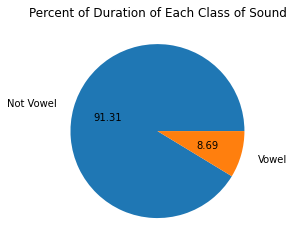

In [16]:
plt.pie(length_of_each_class, labels = ['Not Vowel', 'Vowel'], autopct = '%.2f', labeldistance = 1.2)
plt.title("Percent of Duration of Each Class of Sound")
# plt.savefig('Minor_class_of_sounds.png')

## Visualizing the audio itself

### Waveform

In [18]:
# I'm downsampling the data here to 8000 sr/max of 4000 Hz measurements (https://stackoverflow.com/questions/30619740/downsampling-wav-audio-file)
librosa_audio_02, sr = librosa.load("./original_en_diapix_data/DP_ENF_02_ENF_06_EN_ENF_02_DP_ENF_02_ENF_06_EN_ENF_06.wav", duration = 30, sr = 8000)

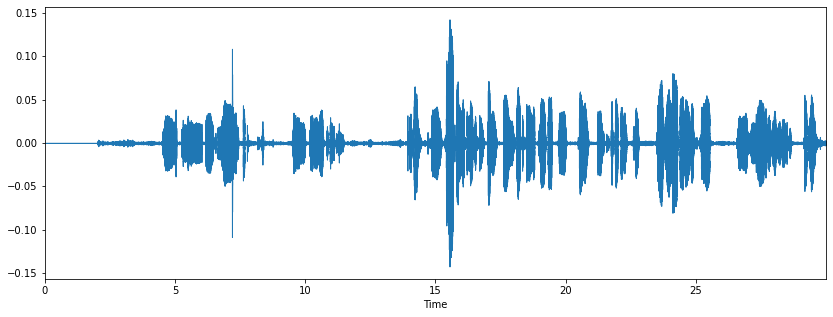

In [19]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(librosa_audio_02, sr=sr)

### Spectrogram

In [17]:
X = librosa.stft(librosa_audio_02)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

NameError: name 'librosa_audio_02' is not defined